# Importing Libraries & Data Preparation

In [1]:
import numpy as np
import pandas as pd
from fastai import *
from fastai.text import *
from fastai.callbacks.tracker import EarlyStoppingCallback
from fastai.callbacks.tracker import SaveModelCallback

from clinical_note_utils import *

from transformers import AutoTokenizer, AutoModel
from transformers import BertForSequenceClassification, BertTokenizer


I0601 20:41:30.350917 140114100832064 file_utils.py:39] PyTorch version 1.0.0 available.


In [2]:
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_Discharge_Summary_BERT")

I0601 20:41:31.386211 140114100832064 configuration_utils.py:285] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/emilyalsentzer/Bio_Discharge_Summary_BERT/config.json from cache at /home/littlefield/.cache/torch/transformers/640beb2c40cee0eea58797d0904d3140b55b32f3cb22ad06903c62f3db6784cd.e99f38979b92a72e708709cb38397fa864caf99dd2e2ed75826560450aa14a0c
I0601 20:41:31.387983 140114100832064 configuration_utils.py:321] Model config BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 28996
}

I0601 20:41:31.390839 140114100832064 tokenization_utils.py:929] Model name 'emilyalsentzer/Bio_Discharge_Summary_BERT' not found in mode

In [3]:
class FastAiBertTokenizer(BaseTokenizer):
    """Wrapper around BertTokenizer to be compatible with fast.ai"""
    def __init__(self, tokenizer: BertTokenizer, max_seq_len: int=128, **kwargs):
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __call__(self, *args, **kwargs):
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length"""
        return ["[CLS]"] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["[SEP]"]

In [4]:
DATA_ROOT = Path("./data")  

train, valid = [pd.read_csv(DATA_ROOT / fname) for fname in ["train_sub.csv", "valid.csv"]]

In [5]:
train.head()

,TEXT,OUTPUT_LABEL
0,Admission Date: [**2107-10-11**] ...,0
1,Admission Date: [**2183-3-12**] Discharge...,0
2,Admission Date: [**2124-3-24**] ...,0
3,Admission Date: [**2155-10-13**] Discha...,1
4,Admission Date: [**2167-4-3**] D...,1


In [6]:
valid.head()

,TEXT,OUTPUT_LABEL
0,Admission Date: [**2143-11-12**] ...,0
1,"Name: [**Known lastname 4191**],[**Known firs...",0
2,"Name: [**Known lastname 8816**], [**Known fir...",0
3,Admission Date: [**2201-6-18**] ...,0
4,,0


In [7]:
fastai_bert_vocab = Vocab(list(tokenizer.vocab.keys()))

In [8]:
fastai_tokenizer = Tokenizer(tok_func=FastAiBertTokenizer(tokenizer, max_seq_len=64), pre_rules=[], post_rules=[])

In [9]:
clinical_data = TextDataBunch.from_df(".", train, valid, 
                  tokenizer=fastai_tokenizer,
                  vocab=fastai_bert_vocab,
                  include_bos=False,
                  include_eos=False,
                  text_cols="TEXT",
                  label_cols="OUTPUT_LABEL",
                  bs=32,
                  collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
             )


In [8]:
clinical_data.save("bert-clinical-sub.pkl")

In [9]:
clinical_data.show_batch()

text,target
[CLS] admission date : [ * * 211 ##6 - 2 - 3 * * ] discharge date : [ * * 211 ##6 - 2 - 7 * * ] date of birth : [ * * 207 ##2 - 4 - 26 * * ] sex : f service : medicine all ##er ##gies : su ##lf ##a ( su ##lf [SEP],0
[CLS] admission date : [ * * 219 ##8 - 3 - 5 * * ] discharge date : [ * * 219 ##8 - 3 - 6 * * ] date of birth : [ * * 212 ##5 - 1 - 13 * * ] sex : m service : medicine all ##er ##gies : no known all ##er ##gies / [SEP],1
"[CLS] name : [ * * known last ##name 62 ##28 * * ] , [ * * known first ##name * * ] unit no : [ * * n ##ume ##ric id ##ent ##ifier 62 ##29 * * ] admission date : [ * * 211 ##8 - 2 - 22 * * ] discharge date : [ * * 211 [SEP]",1
[CLS] admission date : [ * * 214 ##5 - 4 - 22 * * ] discharge date : [ * * 214 ##5 - 5 - 25 * * ] service : medicine all ##er ##gies : apple / l ##isi ##no ##p ##ril attending : [ * * first name ##3 ( l ##f ) 39 ##8 ##4 * * ] [SEP],1
[CLS] admission date : [ * * 214 ##0 - 6 - 3 * * ] discharge date : [ * * 214 ##0 - 6 - 17 * * ] service : medicine all ##er ##gies : pen ##ici ##llin ##s attending : [ * * first name ##3 ( l ##f ) 55 ##2 * * ] chief complaint : di [SEP],1


# BERT Model

In [10]:
clinical_bert = BertForSequenceClassification.from_pretrained("emilyalsentzer/Bio_Discharge_Summary_BERT",
              num_labels = 2)

I0601 19:27:19.952934 140663258277696 configuration_utils.py:285] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/emilyalsentzer/Bio_Discharge_Summary_BERT/config.json from cache at /home/littlefield/.cache/torch/transformers/640beb2c40cee0eea58797d0904d3140b55b32f3cb22ad06903c62f3db6784cd.e99f38979b92a72e708709cb38397fa864caf99dd2e2ed75826560450aa14a0c
I0601 19:27:19.954639 140663258277696 configuration_utils.py:321] Model config BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 28996
}

I0601 19:27:20.208395 140663258277696 modeling_utils.py:617] loading weights file https://cdn.huggingface.co/emilyalsentzer/Bio_Discharge

In [43]:
class CustomTransformerModel(nn.Module):
  
    def __init__(self, transformer_model: BertForSequenceClassification):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, x):
        # Return only the logits from the transfomer
        logits = self.transformer(x)[0]   
        return logits

In [44]:
model = CustomTransformerModel(clinical_bert)

In [51]:
from fastai.callbacks import *

learner = Learner(clinical_data, model, metrics=[AUROC(), Precision(), Recall()])

In [58]:
learner.freeze_to(-1)

In [59]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.10E-06


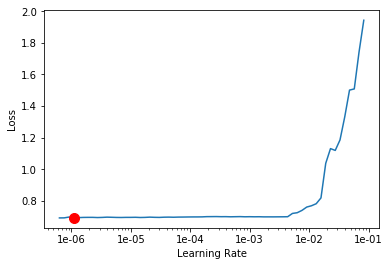

In [54]:
learner.recorder.plot(suggestion=True)

In [60]:
learner.fit_one_cycle(4, 1.1e-6)

epoch,train_loss,valid_loss,auroc,precision,recall,time
0,0.694599,0.697103,0.487447,nan,1.000000,00:39
1,0.696235,0.691853,0.521157,nan,0.000000,00:39


KeyboardInterrupt: 

In [21]:
learner.save("clinical-bert-1")

In [22]:
learner.freeze_to(-2)

In [23]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.31E-06


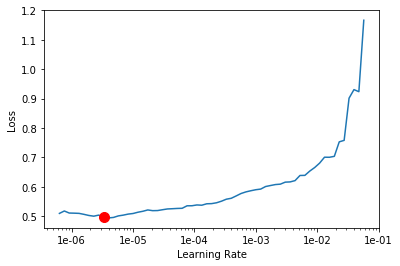

In [24]:
learner.recorder.plot(suggestion=True)

In [25]:
learner.fit_one_cycle(15, max_lr=slice(1e-06), moms=(0.8,0.7), pct_start=0.2)

epoch,train_loss,valid_loss,auroc,precision,recall,time
0,0.516878,0.793671,0.562937,0.079885,0.557778,00:39
1,0.523233,0.802264,0.563799,0.080901,0.566667,00:39
2,0.528419,0.763665,0.562151,0.080875,0.517778,00:39
3,0.524355,0.760634,0.562881,0.081155,0.524444,00:39
4,0.518333,0.785674,0.561912,0.079974,0.546667,00:39
5,0.517381,0.803471,0.562013,0.079251,0.564444,00:40
6,0.506172,0.797097,0.562571,0.079663,0.546667,00:39
7,0.506704,0.775022,0.562532,0.080933,0.524444,00:39
8,0.507074,0.782561,0.562993,0.080054,0.524444,00:39
9,0.505114,0.805129,0.562804,0.079272,0.542222,00:39


In [26]:
learner.save("clinical-bert-2")

In [27]:
learner.freeze_to(-3)

In [28]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.45E-05


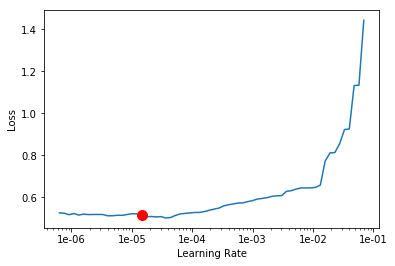

In [29]:
learner.recorder.plot(suggestion=True)

In [30]:
learner.fit_one_cycle(10, max_lr=slice(1e-05), moms=(0.8,0.7), pct_start=0.2)

epoch,train_loss,valid_loss,auroc,precision,recall,time
0,0.518663,0.769905,0.560720,0.079986,0.508889,00:39
1,0.538003,0.753700,0.558200,0.079266,0.451111,00:39
2,0.527547,0.688897,0.549549,0.079585,0.408889,00:39
3,0.511514,0.869201,0.554785,0.076121,0.535556,00:39
4,0.493349,0.945045,0.556767,0.079532,0.588889,00:39
5,0.474638,0.837299,0.554888,0.076344,0.451111,00:39
6,0.456278,0.901958,0.556278,0.079718,0.502222,00:39
7,0.427736,0.893364,0.558300,0.079413,0.468889,00:39
8,0.421978,0.919908,0.556435,0.080628,0.491111,00:39
9,0.404684,0.941057,0.556360,0.079264,0.497778,00:39


In [31]:
learner.save("clinical-bert-3")

In [32]:
learner.unfreeze()

In [33]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.31E-06


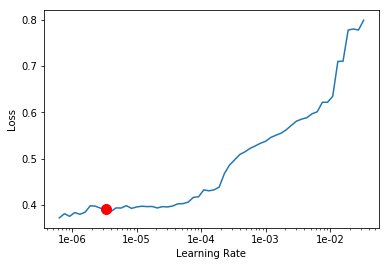

In [34]:
learner.recorder.plot(suggestion=True)

In [35]:
learner.fit_one_cycle(15, max_lr=5e-06, moms=(0.8,0.7), pct_start=0.2)

epoch,train_loss,valid_loss,auroc,precision,recall,time
0,0.407382,0.970141,0.555890,0.080056,0.506667,00:39
1,0.415277,0.883023,0.559207,0.081811,0.437778,00:39
2,0.438272,0.895418,0.551110,0.079249,0.506667,00:40
3,0.421540,0.926756,0.551981,0.080410,0.453333,00:39
4,0.404951,0.953148,0.547174,0.079289,0.475556,00:40
5,0.395463,0.913681,0.548797,0.078947,0.440000,00:39
6,0.385327,0.967187,0.548406,0.076837,0.460000,00:40
7,0.374375,1.049578,0.550919,0.079461,0.497778,00:39
8,0.358395,1.051457,0.549647,0.078606,0.471111,00:39
9,0.345112,1.119926,0.552775,0.080332,0.515556,00:39


In [36]:
learner.save("clinical-bert-unfrozen-1")

In [37]:
test = pd.read_csv(DATA_ROOT / "test.csv")
learner.data.add_test(test.TEXT)

In [38]:
learner.data.test_ds

LabelList (6798 items)
x: TextList
[CLS] admission date : [ * * 217 ##4 - 10 - 21 * * ] discharge date : [ * * 217 ##4 - 11 - 12 * * ] date of birth : [ * * 211 ##8 - 4 - 13 * * ] sex : m service : card ##iot ##hora ##ci ##c all ##er ##gies : pen ##ici [SEP],[CLS] admission date : [ * * 214 ##6 - 11 - 25 * * ] discharge date : [ * * 214 ##6 - 11 - 29 * * ] date of birth : [ * * 209 ##1 - 2 - 15 * * ] sex : m service : card ##iot ##hora ##ci ##c all ##er ##gies : code ##ine [SEP],[CLS] admission date : [ * * 210 ##8 - 4 - 1 * * ] discharge date : [ * * 210 ##8 - 4 - 8 * * ] date of birth : [ * * 208 ##6 - 11 - 6 * * ] sex : m service : surgery all ##er ##gies : no known all ##er ##gies / [SEP],[CLS] admission date : [ * * 212 ##9 - 6 - 23 * * ] discharge date : [ * * 212 ##9 - 7 - 6 * * ] date of birth : [ * * 208 ##2 - 10 - 26 * * ] sex : f service : card ##iot ##hora ##ci ##c all ##er ##gies : le ##vo [SEP],[CLS] admission date : [ * * 215 ##9 - 9 - 14 * * ] discharge date : [ * * 215

In [39]:
preds = learner.get_preds(DatasetType.Test)

In [40]:
final_preds = [1 if p > 0.5 else 0 for p in preds[0][:, 1]]

In [41]:
from sklearn.metrics import confusion_matrix

In [42]:
confusion_matrix(test.OUTPUT_LABEL, final_preds)

array([[3756, 2584],
       [ 252,  206]])